# Baseline experiment

## Load the model

In [2]:
from baseline import BaselineModel
from torchsummary import summary
import torch

In [3]:
model = BaselineModel()

In [4]:
summary(model, (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             544
              ReLU-2         [-1, 32, 128, 128]               0
       BatchNorm2d-3         [-1, 32, 128, 128]              64
            Conv2d-4           [-1, 64, 64, 64]          32,832
              ReLU-5           [-1, 64, 64, 64]               0
       BatchNorm2d-6           [-1, 64, 64, 64]             128
            Conv2d-7          [-1, 128, 32, 32]         131,200
              ReLU-8          [-1, 128, 32, 32]               0
       BatchNorm2d-9          [-1, 128, 32, 32]             256
           Conv2d-10          [-1, 128, 16, 16]         262,272
             ReLU-11          [-1, 128, 16, 16]               0
      BatchNorm2d-12          [-1, 128, 16, 16]             256
  ConvTranspose2d-13           [-1, 64, 32, 32]         131,136
             ReLU-14           [-1, 64,

### Hyperparameters

In [5]:
from torch.optim import Adam
from torch.nn import MSELoss
from torch import cuda

learning_rate = 1e-3
batch_size = 512
optimizer = Adam(model.parameters(), lr=learning_rate)
criterion = MSELoss()
epochs = 10
device = 'cuda' if cuda.is_available() else 'cpu'

## Load CIFAR10

In [8]:
import numpy as np
from skimage import color

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

def import_image(img):
    return torch.FloatTensor(np.transpose(color.rgb2lab(np.array(img)), (2,0,1)))

img_transform = transforms.Compose([
    transforms.Lambda(import_image),
])

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=img_transform, target_transform=None)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CIFAR10(root='./data', train=False, download=True, transform=img_transform, target_transform=None)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


## Train the model

In [10]:
model.train()

print('Training...')

train_loss_avg = []

for epoch in range(epochs):
    train_loss_avg.append(0)
    num_batches = 0

    for batch, _ in train_loader:
        batch = batch.to(device)

        prediction_ab = model(batch[:,0:1,:,:])

        loss = criterion(prediction_ab, batch[:,1:3,:,:])

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        train_loss_avg[-1] += loss.item()
        num_batches += 1

    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, epochs, train_loss_avg[-1]))

Training...
Epoch [1 / 10] average reconstruction error: 178.733595
Epoch [2 / 10] average reconstruction error: 162.107235
Epoch [3 / 10] average reconstruction error: 153.225383
Epoch [4 / 10] average reconstruction error: 145.268098
Epoch [5 / 10] average reconstruction error: 137.887703
Epoch [6 / 10] average reconstruction error: 130.862146
Epoch [7 / 10] average reconstruction error: 123.176101
Epoch [8 / 10] average reconstruction error: 115.682321
Epoch [9 / 10] average reconstruction error: 108.375594
Epoch [10 / 10] average reconstruction error: 102.137511


## Model evaluation

In [11]:
# set to evaluation mode
model.eval()

test_loss_avg, num_batches = 0, 0
for lab_batch, _ in test_loader:

    with torch.no_grad():

        lab_batch = lab_batch.to(device)

        # apply the color net to the luminance component of the Lab images
        # to get the color (ab) components
        predicted_ab_batch = model(lab_batch[:, 0:1, :, :])

        # loss is the L2 error to the actual color (ab) components
        loss = criterion(predicted_ab_batch, lab_batch[:, 1:3, :, :])

        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average loss: %f' % (test_loss_avg))

average loss: 164.931004


## Results Visualisation

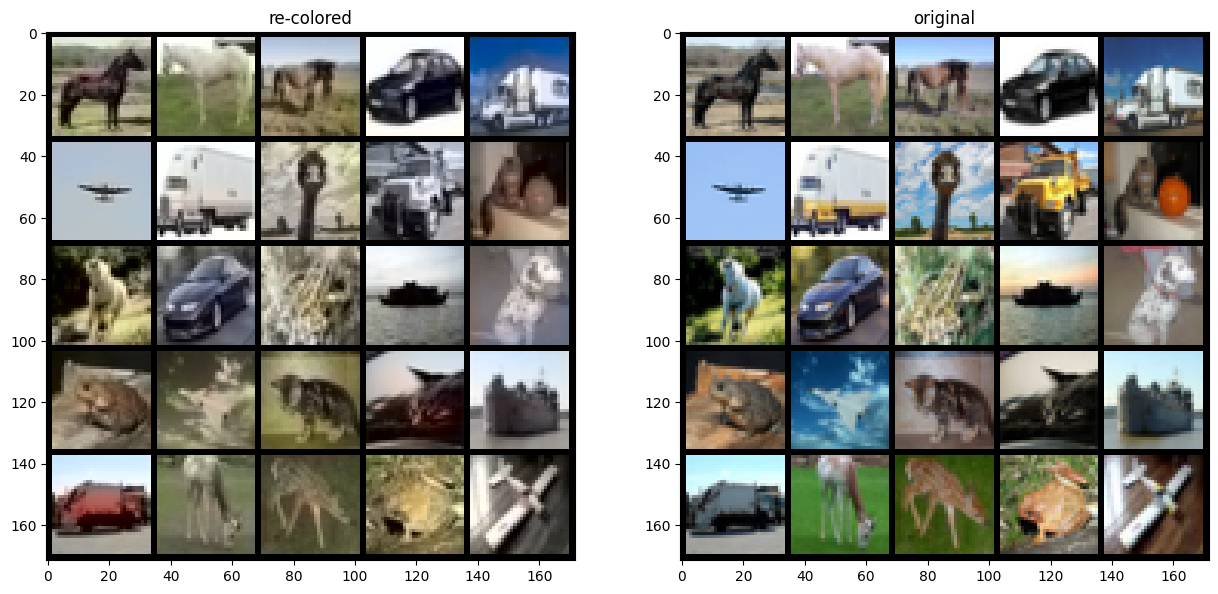

In [12]:
import numpy as np
from skimage import color, io

import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

with torch.no_grad():

    # pick a random subset of images from the test set
    image_inds = np.random.choice(len(test_dataset), 25, replace=False)
    lab_batch = torch.stack([test_dataset[i][0] for i in image_inds])
    lab_batch = lab_batch.to(device)

    # predict colors (ab channels)
    predicted_ab_batch = model(lab_batch[:, 0:1, :, :])
    predicted_lab_batch = torch.cat([lab_batch[:, 0:1, :, :], predicted_ab_batch], dim=1)

    lab_batch = lab_batch.cpu()
    predicted_lab_batch = predicted_lab_batch.cpu()

    # convert to rgb
    rgb_batch = []
    predicted_rgb_batch = []
    for i in range(lab_batch.size(0)):
        rgb_img = color.lab2rgb(np.transpose(lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
        rgb_batch.append(torch.FloatTensor(np.transpose(rgb_img, (2, 0, 1))))
        predicted_rgb_img = color.lab2rgb(np.transpose(predicted_lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
        predicted_rgb_batch.append(torch.FloatTensor(np.transpose(predicted_rgb_img, (2, 0, 1))))

    # plot images
    fig, ax = plt.subplots(figsize=(15, 15), nrows=1, ncols=2)
    ax[0].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(predicted_rgb_batch), nrow=5).numpy(), (1, 2, 0)))
    ax[0].title.set_text('re-colored')
    ax[1].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(rgb_batch), nrow=5).numpy(), (1, 2, 0)))
    ax[1].title.set_text('original')
    plt.show()


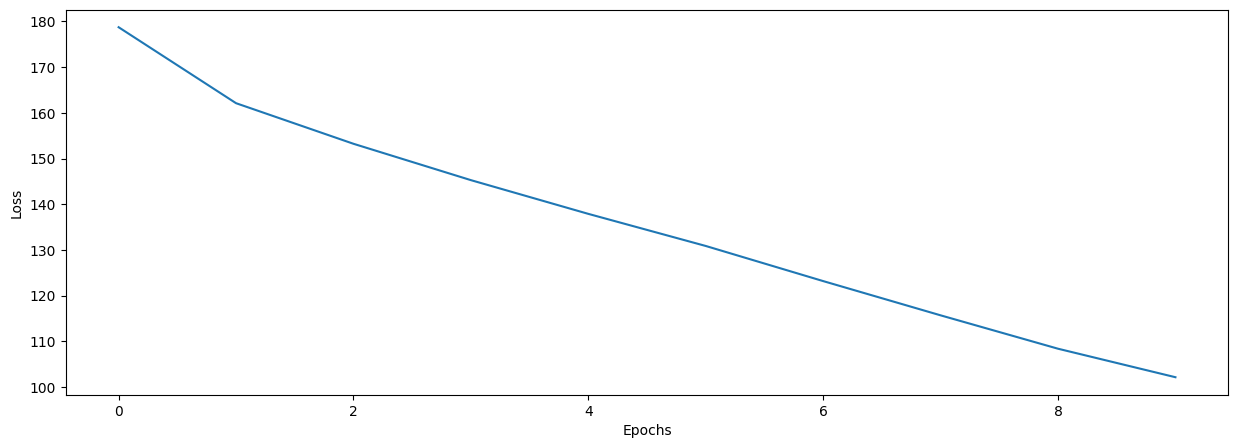

In [13]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure(figsize=(15, 5))
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()